# TNR Balance Framework
In order to properly balance the game we need a reference framework. The goal of this framework is to define the rough overall scale e.g. damage etc in simple settings, while not neccesarily strictly accounting for secondary effects etc. which can tilt balance on a more granular level. In this proposal, we parameterize this overall framework by a set of interpretable variables, based on which various formulas can be derived. The objectives of the framework:

**Levels & Capping**
* Take about 12 months of play to cap [considering ~6h play per day]

**Pools**
* Keep pools under control, so as to not end in an exponential number situation (i.e. no cookie clicker situation).
* Aim for +1 regen at each rank (keep pools under control!)

**Damage Length**
* Should take ~10 hits to kill user of same strength with equal stats distribution.
* Should take ~5 hits to kill user of same strength with favorable stats distribution.
* Should take ~3 hits to kill user 10x weaker with same stats distribution.
* Should take ~1 hit to kill user 10x weaker with favorable stats distribution.

**Ryo**
* Ryo from ~2 arena fights should be enough to get out hospital at any level
* Ryo from 2^[jutsu level] arena fights should be enough to level jutsu

In [90]:
POOL_PER_LEVEL = 10
REGEN_PER_RANK = 1
KO_HITS_EQUAL_BALANCED = 10
KO_HITS_EQUAL_UNBALANCED = 5
KO_HITS_UNEQUAL_BALANCED = 3
KO_HITS_UNEQUAL_UNBALANCED = 1
ARENA_FIGHTS_PER_HOSPITAL_BILL = 2
ARENA_FIGHTS_PER_JUTSU_LEVEL = 1
ENERGY_SPENT_PER_SECOND = 0.1 # Training Stats per Second
EXTRA_EXP_REQUIRED_PER_LEVEL = 500
LEVEL_2_RANK = {10: 2, 20: 3, 50: 4, 80: 5, 100: 6}

# Estimates for battle activity against equal opponents (elo gain 16 with K-factor 32)
ESTIMATED_HIGH_BATTLES_PER_HOUR = 60
ESTIMATED_LOW_BATTLES_PER_HOUR = 20
ESTIMATED_BATTLES_PER_HOUR = 40
ELO_GAIN = 16

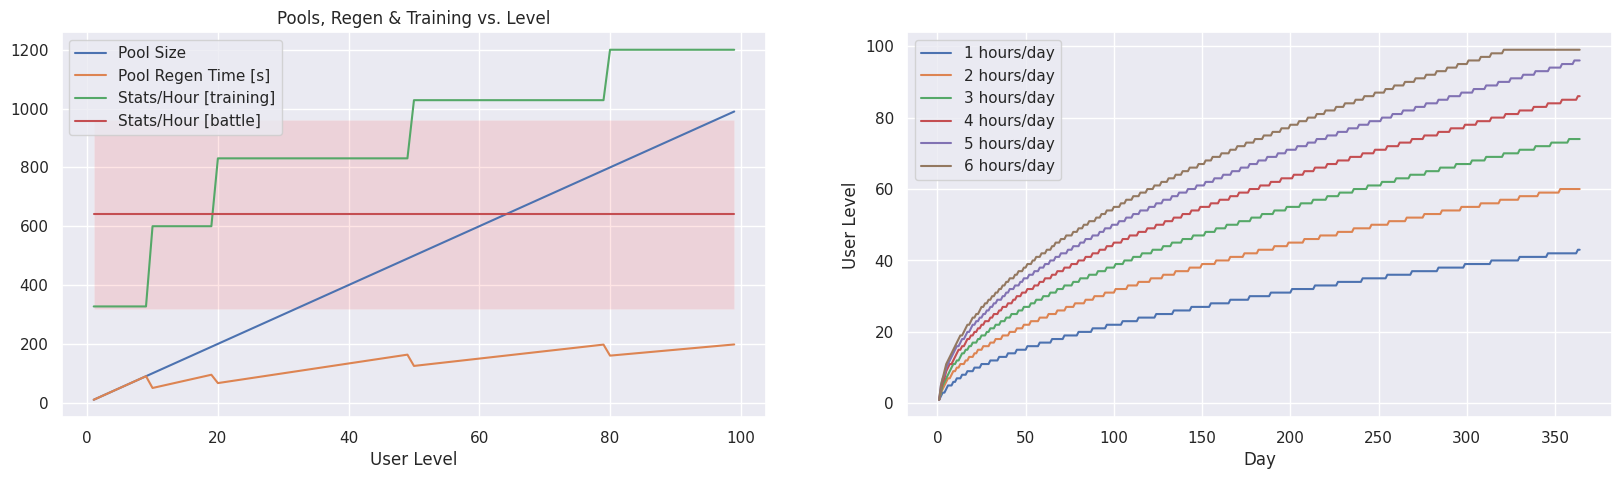

In [127]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Create Dataframe
df = pd.DataFrame({'User Level': np.arange(1, 100)})
df['Regen'] = df['User Level'].apply(lambda x: 1 if x in LEVEL_2_RANK else 0).cumsum() + 1
df['Experience'] = df['User Level'].apply(lambda x: EXTRA_EXP_REQUIRED_PER_LEVEL * x).cumsum()
df['Pool Size'] = df['User Level'].apply(lambda x: POOL_PER_LEVEL * x)
df['Pool Regen Time [s]'] = df['Pool Size'] / df['Regen']
df['Trainings/Hour'] = 3600 / (df['Pool Regen Time [s]'] + df['Pool Size'] * ENERGY_SPENT_PER_SECOND)
df['Stats/Hour [training]'] = df['Pool Size'] * ENERGY_SPENT_PER_SECOND * df['Trainings/Hour']
df['Stats/Hour [battle]'] = ESTIMATED_BATTLES_PER_HOUR * ELO_GAIN
df['Low Stats/Hour [battle]'] = ESTIMATED_LOW_BATTLES_PER_HOUR * ELO_GAIN
df['High Stats/Hour [battle]'] = ESTIMATED_HIGH_BATTLES_PER_HOUR * ELO_GAIN
df['Total Stats/Hour'] = df['Low Stats/Hour [battle]'] + df['High Stats/Hour [battle]']
df = df.set_index('User Level')

# Set up subplots
_, axes = plt.subplots(1, 2, figsize=(20, 5))

# Create pools, regen & training plots
axes[0].fill_between(df.index, df['Low Stats/Hour [battle]'], df['High Stats/Hour [battle]'],alpha=0.1, facecolor="red")
df.plot(y='Pool Size', ax=axes[0])
df.plot(y='Pool Regen Time [s]', ax=axes[0])
df.plot(y='Stats/Hour [training]', ax=axes[0])
df.plot(y='Stats/Hour [battle]', ax=axes[0])
axes[0].set_title('Pools, Regen & Training vs. Level')

# Create levelling & cap plots
for hours_per_day in [1, 2, 3, 4, 5, 6]:
    column = f"{hours_per_day} hours/day"
    time_df = pd.DataFrame({'Day': np.arange(1, 365), column: 1, 'experience': 0})
    for day, row in time_df.iterrows():
        time_df.loc[day:, column] = df.assign(diff=np.abs(df.Experience - time_df.loc[day].experience)).sort_values('diff').index[0]
        time_df.loc[day:, 'experience'] += hours_per_day * df.loc[row[column], 'Total Stats/Hour']
    time_df.plot(x='Day', y=column, ax=axes[1])
    axes[1].set_ylabel('User Level')
plt.show()